In [ ]:
# # 데이터 로드하기

# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab
# !bash install_mecab-ko_on_colab190912.sh

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
my_path = '/content/notebooks'

Mounted at /content/drive


In [ ]:
import pandas as pd

# TSV 파일 경로
tsv_file = r'/content/drive/MyDrive/data_review/archive/kr3.tsv'

# TSV 파일 불러오기
df = pd.read_csv(tsv_file, delimiter='\t')

# 데이터 활용
# ...


In [ ]:
# df.to_excel(r'/content/drive/MyDrive/data_review/archive/kr3.xlsx')

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 38.7 MB/s eta 0:00:00


In [ ]:
import re
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

In [ ]:
# total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
# print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

total_data = df
print('전체 리뷰 개수 : ' , len(df))

전체 리뷰 개수 :  641762


In [ ]:
total_data[:5]

,Rating,Review
0,1,숙성 돼지고기 전문점입니다. 건물 모양 때문에 매장 모양도 좀 특이하지만 쾌적한 편...
1,1,고기가 정말 맛있었어요! 육즙이 가득 있어서 너무 좋았아요 일하시는 분들 너무 친절...
2,1,"잡내 없고 깔끔, 담백한 맛의 순댓국이 순댓국을 안 좋아하는 사람들에게도 술술 넘어..."
3,1,고기 양이 푸짐해서 특 순대국밥을 시킨 기분이 듭니다 맛도 좋습니다 다만 양념장이 ...
4,1,순댓국 자체는 제가 먹어본 순대국밥집 중에서 Top5 안에는 들어요. 그러나 밥 양...


In [ ]:
# # 2 훈련데이터와 테스트 데이터 분리하기

# # 현재 갖고 있는 데이터는 레이블을 별도로 갖고있지 않습니다. 
# # 평점이 4, 5인 리뷰에는 레이블 1을, 평점이 1, 2인 리뷰에는 레이블 0을 부여합니다. 
# # 부여된 레이블은 새로 생성한 label이라는 열에 저장합니다.

# total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
# total_data[:5]

# total_data = total_data.query('Rating != 2').reset_index(drop=True)[:300000]
# total_data = total_data.query('Rating != 2').reset_index(drop=True)[:10000]

# positive_data = total_data.query('Rating == 1').reset_index(drop=True)[:10000]
# negative_data = total_data.query('Rating == 0').reset_index(drop=True)[:10000]

total_data = df

positive_data = total_data.query('Rating == 1').reset_index(drop=True)[:70000]
negative_data = total_data.query('Rating == 0').reset_index(drop=True)[:70000]

print(positive_data[:10])
print(negative_data[:10])

total_data = pd.concat([positive_data , negative_data] , axis = 0).reset_index(drop=True)

   Rating                                             Review
0       1  숙성 돼지고기 전문점입니다. 건물 모양 때문에 매장 모양도 좀 특이하지만 쾌적한 편...
1       1  고기가 정말 맛있었어요! 육즙이 가득 있어서 너무 좋았아요 일하시는 분들 너무 친절...
2       1  잡내 없고 깔끔, 담백한 맛의 순댓국이 순댓국을 안 좋아하는 사람들에게도 술술 넘어...
3       1  고기 양이 푸짐해서 특 순대국밥을 시킨 기분이 듭니다 맛도 좋습니다 다만 양념장이 ...
4       1  순댓국 자체는 제가 먹어본 순대국밥집 중에서 Top5 안에는 들어요. 그러나 밥 양...
5       1  괜찮아요. 가격 대비 양 많고... 무난한 식당이었네요. 순댓국은 푸짐한 느낌이고 ...
6       1  순대를 시키면 국물이 서비스로 나옴. 순대국밥에서 돼지 누린내가 나지 않고 깔끔하고...
7       1                진한 국물에 건더기도 많음. 김치도 맛있고 직원분들도 친절했음.
8       1          가락동에 있는 유명한 순대국밥집이에요. 양도 많고 친절해서 일부러 찾아가요
9       1                   맛있어요 항상 가는 단골이에요. 냄새도 안 나고 구수해요.
   Rating                                             Review
0       0  그냥 좀 후회되었어요 자리 앉아서 주문하려는데 몇 번을 불러도 안 오시고 주문했는데...
1       0  소문에 비해 음식 맛 별로임, 김치, 부추, 풋고추 등 안 주고 들깨가루 고추 양념...
2       0                       후기 보고 갔으나 내 인생 최악의 순댓국 다신 안감
3       0  오래된 맛 집이나 순대나 고기에서 냄새가 날 때가 있고 가격에 비해 퀄리티가 괜찮은...
4       0  여러 번 시도 끝에 드디

In [ ]:
positive_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rating  70000 non-null  int64 
 1   Review  70000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
negative_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rating  70000 non-null  int64 
 1   Review  70000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
total_data.rename(columns={'Rating': 'label' , 'Review' : 'reviews'}, inplace=True)
total_data


,label,reviews
0,1,숙성 돼지고기 전문점입니다. 건물 모양 때문에 매장 모양도 좀 특이하지만 쾌적한 편...
1,1,고기가 정말 맛있었어요! 육즙이 가득 있어서 너무 좋았아요 일하시는 분들 너무 친절...
2,1,"잡내 없고 깔끔, 담백한 맛의 순댓국이 순댓국을 안 좋아하는 사람들에게도 술술 넘어..."
3,1,고기 양이 푸짐해서 특 순대국밥을 시킨 기분이 듭니다 맛도 좋습니다 다만 양념장이 ...
4,1,순댓국 자체는 제가 먹어본 순대국밥집 중에서 Top5 안에는 들어요. 그러나 밥 양...
...,...,...
139995,0,여기서 절대 먹지 마세요 먹고 일주일 내내 배탈 설사했음 항의하니 담당자 외국 갔...
139996,0,흑돼지 스테이크 너무 정체 모를 맛 완전히 거부스러웠어요.. 흙.. 비위가 약한 분...
139997,0,가격이 많이 비싼 거 같아요 그에 비해 맛은 별로인 등.. 호불호가 갈리는 맛 집인...
139998,0,아니 별로라고요


- conList = [arr>200, arr>100, arr>0]
- choiceList=['A','B','C']
- np.select(conList,choiceList)
### arr>200이면 'A', 그 외 arr>100이면 'B',그 외 arr>0이면 'C' 출력

In [ ]:
# 각 열에 대해서 중복을 제외한 샘플의 수를 카운트합니다.

total_data['reviews'].nunique(), total_data['label'].nunique()

(139895, 2)

In [ ]:
# ratings열의 경우 1, 2, 4, 5라는 네 가지 값을 가지고 있습니다. 
# reviews열에서 중복을 제외한 경우 199,908개입니다. 
# 현재 20만개의 리뷰가 존재하므로 이는 현재 갖고 있는 데이터에 중복인 샘플들이 있다는 의미입니다. 중복인 샘플들을 제거해줍니다.

total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 139895


In [ ]:
# NULL 값 유무를 확인합니다.
print(total_data.isnull().values.any())

False


In [ ]:
# 훈련 데이터와 테스트 데이터를 3:1 비율로 분리합니다.

train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 104921
테스트용 리뷰의 개수 : 34974


   label  count
0      0  52494
1      1  52427


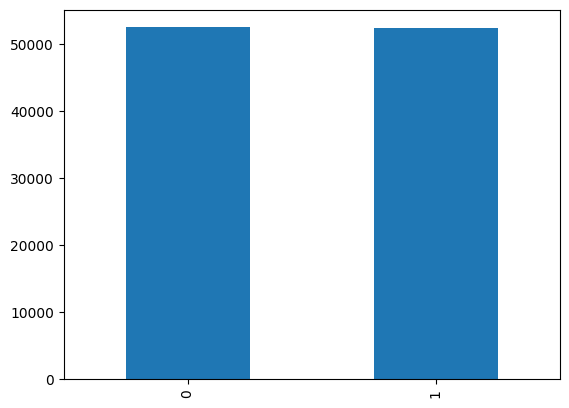

In [ ]:
 # 3 레이블의 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [ ]:
# 4 데이터 정제하기
# 정규 표현식을 사용하여 한글을 제외하고 모두 제거해줍니다. 또한 혹시 이 과정에서 빈 샘플이 생기지는 않는지 확인합니다.

# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
train_data[train_data.isnull().reviews]

<ipython-input-18-aad058a02db5>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


label       0
reviews    22
dtype: int64


,label,reviews
100484,0,NaN
119125,0,NaN
85599,0,NaN
93394,0,NaN
126423,0,NaN
98839,0,NaN
95855,0,NaN
101620,0,NaN
134230,0,NaN
77774,0,NaN


In [ ]:
train_data = train_data.dropna(how='any') # Null 값 제거

In [100]:
train_data.isnull().sum()
train_data = train_data.reset_index(drop=True)
train_data

,label,reviews
0,0,난 별로 많이 달다 먼저 왔는데도 늦게 온 테이블부터 세팅 나가고 블로그 맛 집에 ...
1,1,분짜가 정말 정말 맛있었어요 강추합니다 또 가고 싶을 정도네요
2,0,너어어어엉어어어어어무 기대해서 그런가 별로였다 딱히 특별하지 않은 맛 결정적으로 패...
3,1,아보카도 올라가있는 카레 궁금해서 먹어봤는데 만족스러웠어요
4,0,향신료향이 강해서 개인적으로는 불호였지만 육즙은 엄청났다 바삭거림도 엄청나고 중국 ...
...,...,...
104894,0,최악이에요 안 씻은 그릇 얘기해도 넘쳐서 그런 거라 하고 심지어 컵에도 짬뽕 가득 ...
104895,0,아오 비추 부개 찌개 집일 때부터 간혹 갔던 집인데 너무 많이 불편 불친절 해졌어 ...
104896,0,빵 겁나 맛없음 커피도
104897,0,음료는 미지근 밍밍 증편 떡 구이는 따뜻하긴 한데 같이 내어주시는 발사믹이 너무 강...


In [ ]:
# 테스트 데이터에도 같은 과정

test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
#df_cleaned = df.dropna(subset=[column_name])
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 34966


<ipython-input-21-cf80dcc42450>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [ ]:
test_data.isnull().sum()

label      0
reviews    0
dtype: int64

In [ ]:
from konlpy.tag import Okt
okt = Okt()

In [ ]:
# # okt 

# # morphs() : 텍스트를 형태소 단위로 나눈다.
# # 옵션 : norm, stem. norm은 normalize의 약자로 문장의 정규화 여부를 정하는 옵션이다. 
# # stem은 각 단어에서 어간을 추출할지 정하는 옵션이다. 기본값은 둘 다 False.
# # nouns() : 텍스트에서 명사만 추출한다.
# # phrases() : 텍스트에서 어절을 추출한다.
# # pos() : 텍스트를 형태소 단위로 나눈 뒤, 형태소와 품사 정보를 리스트화한 결과를 반환한다.
# # pos() 함수도 norm, stem 옵션이 있다.

# # okt 연습 실행
# # 패키지를 못찾을 경우 경로 설정을 다시해보자
# # %cd /content/drive/MyDrive/Colab Notebooks/my_env

# # norm = True
# # norm은 정규화 여부 확인이다. -> 오타를 검증해줌


# okt = Okt()
# print(okt.pos('닭가슴살 라임맛 좋고 라임향 힘쌔고 제로슈거 힘듬 배송상태 특유 콜라향 탄산음료 제로칼로리음료' 
#         , norm = True , stem = True))
# print(okt.pos('닭가슴살 라임맛 좋고 라임향 힘쌔고 제로슈거 힘듬 배송상태 특유 콜라향 탄산음료 제로칼로리음료' 
#         , norm = False , stem = False)
# )

In [ ]:
# okt.morphs('닭가슴살 라임맛 좋고 라임향 힘쌔고 제로슈거 힘듬 배송상태 특유 콜라향 탄산음료 제로칼로리음료')

In [ ]:
# 5 토큰화
# 형태소 분석기 Mecab을 사용하여 토큰화 작업을 수행합니다. 다음은 임의의 문장에 대해서 테스트한 토큰화 결과입니다.

# mecab = Mecab()
# print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

In [101]:
# 불용어를 지정하여 필요없는 토큰들은 제거하도록 합니다.

stopwords = ['도', '는', '다', '의', '가', '이', '은', 
             '한', '에', '하', '고', '을', '를', '인', '듯', 
             '과', '와', '네', '들', '듯', '지', '임', '게' , 
             '는' ,'이','인데','이가','했었','했','습니다','슴','음' ,
             '것' ,'거' ,'로' ,'들' ,'거' ,'것' ,'곳' , '분' , '원' ,
             '입니다' ,'해서' ,'더' ,'왜' ,'수' ,'할' , '그' ,'함' ,'돈' ,'번' ,
             '두' ,'개' ,'했는데' ,'건' ,'내' , '저' ,'만' ,'갈','걸','제','명' ,
             '분' ,'해']

In [102]:
train_data['tokenized'] = train_data['reviews'].apply(okt.pos)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [word for word,shape in x if shape in ['Verb' , 'Adjective' , 'Noun' , 'VerbPrefix'] if word not in stopwords])

In [103]:
train_data.to_csv(r'/content/drive/MyDrive/data_review/archive/train_data_main.csv' , index=False , encoding = 'euc-kr')

In [104]:
test_data['tokenized'] = test_data['reviews'].apply(okt.pos)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [word for word,shape in x if shape in ['Verb' , 'Adjective' , 'Noun' , 'VerbPrefix'] if word not in stopwords])

In [105]:
test_data.to_csv(r'/content/drive/MyDrive/data_review/archive/test_data_main.csv' , index=False , encoding = 'euc-kr')

In [ ]:
# 6 단어와 길이 분포 확인

In [106]:
# 긍정 리뷰에는 주로 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 
# 두 가지 경우에 대해서 각 단어의 빈도수를 계산해보겠습니다. 
# 각 레이블에 따라서 별도로 단어들의 리스트를 저장해줍니다.

negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [107]:
# 긍정 리뷰에는 주로 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 
# 두 가지 경우에 대해서 각 단어의 빈도수를 계산해보겠습니다. 
# 각 레이블에 따라서 별도로 단어들의 리스트를 저장해줍니다.

negative_words_test = np.hstack(test_data[test_data.label == 0]['tokenized'].values)
positive_words_test = np.hstack(test_data[test_data.label == 1]['tokenized'].values)

In [108]:
# Counter()를 사용하여 각 단어에 대한 빈도수를 카운트합니다. 우선 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력합니다.

negative_word_test_count = Counter(negative_words_test)
print(negative_word_test_count.most_common(50))

[('맛', 10981), ('안', 6632), ('별로', 3068), ('집', 3011), ('그냥', 2997), ('가격', 2865), ('음식', 2649), ('사람', 2145), ('직원', 2119), ('못', 2118), ('하는', 2086), ('주문', 1948), ('정말', 1888), ('정도', 1881), ('손님', 1869), ('좀', 1867), ('때', 1781), ('고기', 1765), ('서비스', 1715), ('생각', 1661), ('말', 1654), ('진짜', 1595), ('방문', 1588), ('다른', 1510), ('먹고', 1479), ('잘', 1430), ('하나', 1415), ('밥', 1357), ('여기', 1299), ('느낌', 1260), ('기분', 1221), ('시간', 1206), ('먹을', 1197), ('줄', 1188), ('있는', 1163), ('메뉴', 1157), ('하고', 1154), ('테이블', 1101), ('커피', 1098), ('먹는', 1087), ('최악', 1070), ('사장', 1040), ('빵', 1031), ('양', 1020), ('점', 1008), ('식당', 1004), ('다시', 992), ('없고', 985), ('전', 959), ('처음', 927)]


In [109]:
for word , count in negative_word_test_count.most_common(100) :
  print(f'{word} : {count}')

맛 : 10981
안 : 6632
별로 : 3068
집 : 3011
그냥 : 2997
가격 : 2865
음식 : 2649
사람 : 2145
직원 : 2119
못 : 2118
하는 : 2086
주문 : 1948
정말 : 1888
정도 : 1881
손님 : 1869
좀 : 1867
때 : 1781
고기 : 1765
서비스 : 1715
생각 : 1661
말 : 1654
진짜 : 1595
방문 : 1588
다른 : 1510
먹고 : 1479
잘 : 1430
하나 : 1415
밥 : 1357
여기 : 1299
느낌 : 1260
기분 : 1221
시간 : 1206
먹을 : 1197
줄 : 1188
있는 : 1163
메뉴 : 1157
하고 : 1154
테이블 : 1101
커피 : 1098
먹는 : 1087
최악 : 1070
사장 : 1040
빵 : 1031
양 : 1020
점 : 1008
식당 : 1004
다시 : 992
없고 : 985
전 : 959
처음 : 927
갔는데 : 899
가게 : 880
가지 : 878
같은 : 867
자리 : 866
국물 : 830
중 : 814
없는 : 806
건지 : 805
뭐 : 795
일 : 789
분위기 : 785
보고 : 784
이런 : 777
없음 : 747
나 : 735
시 : 720
먹어 : 719
반찬 : 701
불친절 : 699
합니다 : 698
실망 : 686
리뷰 : 662
냄새 : 652
절대 : 645
하면 : 645
소스 : 642
식사 : 637
같아요 : 629
위생 : 624
않고 : 622
가서 : 620
먹었는데 : 613
장사 : 608
추천 : 605
요 : 592
앞 : 585
좋은 : 581
재 : 581
기본 : 571
조금 : 566
몇 : 563
별 : 563
그런 : 562
때문 : 561
아닌 : 559
카페 : 558
튀김 : 556
아니고 : 550
면 : 549


In [110]:
negative_words

array(['난', '별로', '달다', ..., '사서', '먹으면', '꿀이긴'], dtype='<U32')

In [111]:
positive_words

array(['짜가', '정말', '정말', ..., '가락국수', '먹어', '봐야'], dtype='<U32')

In [112]:
# Counter()를 사용하여 각 단어에 대한 빈도수를 카운트합니다. 우선 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력합니다.

negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(50))

[('맛', 33060), ('안', 20121), ('그냥', 9508), ('별로', 9295), ('집', 8899), ('가격', 8753), ('음식', 8048), ('직원', 6587), ('사람', 6528), ('하는', 6197), ('못', 6088), ('주문', 6073), ('정도', 6028), ('손님', 5785), ('정말', 5540), ('좀', 5522), ('고기', 5498), ('때', 5273), ('서비스', 5258), ('말', 5071), ('생각', 5002), ('다른', 4698), ('진짜', 4695), ('방문', 4676), ('먹고', 4442), ('잘', 4242), ('하나', 4115), ('시간', 3910), ('밥', 3816), ('여기', 3811), ('먹을', 3773), ('줄', 3736), ('느낌', 3673), ('테이블', 3622), ('기분', 3559), ('하고', 3489), ('있는', 3468), ('메뉴', 3418), ('최악', 3394), ('커피', 3226), ('다시', 3207), ('점', 3145), ('식당', 3136), ('먹는', 3059), ('빵', 3056), ('없고', 2879), ('양', 2853), ('전', 2849), ('가게', 2810), ('사장', 2750)]


In [113]:
for word , count in negative_word_count.most_common(100) :
  print(f'{word} : {count}')

맛 : 33060
안 : 20121
그냥 : 9508
별로 : 9295
집 : 8899
가격 : 8753
음식 : 8048
직원 : 6587
사람 : 6528
하는 : 6197
못 : 6088
주문 : 6073
정도 : 6028
손님 : 5785
정말 : 5540
좀 : 5522
고기 : 5498
때 : 5273
서비스 : 5258
말 : 5071
생각 : 5002
다른 : 4698
진짜 : 4695
방문 : 4676
먹고 : 4442
잘 : 4242
하나 : 4115
시간 : 3910
밥 : 3816
여기 : 3811
먹을 : 3773
줄 : 3736
느낌 : 3673
테이블 : 3622
기분 : 3559
하고 : 3489
있는 : 3468
메뉴 : 3418
최악 : 3394
커피 : 3226
다시 : 3207
점 : 3145
식당 : 3136
먹는 : 3059
빵 : 3056
없고 : 2879
양 : 2853
전 : 2849
가게 : 2810
사장 : 2750
처음 : 2709
자리 : 2669
갔는데 : 2668
국물 : 2575
가지 : 2562
분위기 : 2505
보고 : 2447
건지 : 2432
없는 : 2431
뭐 : 2427
이런 : 2395
나 : 2387
시 : 2372
먹어 : 2362
일 : 2362
없음 : 2350
같은 : 2347
중 : 2333
실망 : 2198
반찬 : 2051
합니다 : 2042
불친절 : 2026
리뷰 : 2023
같아요 : 1978
않고 : 1975
식사 : 1934
좋은 : 1934
냄새 : 1922
먹었는데 : 1910
하면 : 1897
카페 : 1896
소스 : 1888
가서 : 1874
절대 : 1869
요 : 1847
추천 : 1803
때문 : 1792
사진 : 1782
위생 : 1772
파스타 : 1771
앞 : 1762
튀김 : 1752
몇 : 1742
장사 : 1731
면 : 1721
아닌 : 1718
아니고 : 1715
조금 : 1712
그런 : 1706
재 : 1701


In [114]:
## '네요', '는데', '안', '않', '너무', '없' 등과 같은 단어들이 부정 리뷰에서 주로 등장합니다. 긍정 리뷰에 대해서도 출력해봅시다.
# 맛 안 너무 으로 만 음식 가격 집 그냥 하고 ? 판단이 가능한가?

positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('맛', 28729), ('집', 11559), ('가격', 9827), ('맛있어요', 7343), ('정말', 6620), ('있는', 6328), ('방문', 6317), ('메뉴', 6039), ('잘', 5989), ('음식', 5965), ('안', 5875), ('분위기', 5849), ('고기', 5418), ('좀', 5294), ('때', 5211), ('사람', 4602), ('추천', 4521), ('좋은', 4499), ('좋아요', 4435), ('양', 4405)]


In [115]:
for word , count in positive_word_count.most_common(100) :
  print(f'{word} : {count}')

맛 : 28729
집 : 11559
가격 : 9827
맛있어요 : 7343
정말 : 6620
있는 : 6328
방문 : 6317
메뉴 : 6039
잘 : 5989
음식 : 5965
안 : 5875
분위기 : 5849
고기 : 5418
좀 : 5294
때 : 5211
사람 : 4602
추천 : 4521
좋은 : 4499
좋아요 : 4435
양 : 4405
먹을 : 4227
카페 : 4203
진짜 : 4165
정도 : 4149
먹고 : 3987
생각 : 3958
맛있고 : 3944
밥 : 3907
주문 : 3857
하는 : 3848
국물 : 3818
조금 : 3791
느낌 : 3772
커피 : 3628
같아요 : 3562
가게 : 3557
먹어 : 3507
있어서 : 3433
합니다 : 3395
다른 : 3308
좋고 : 3050
맛있는 : 3021
식당 : 3020
먹는 : 3011
시간 : 2990
맛있었어요 : 2984
성비 : 2898
주차 : 2795
식사 : 2770
하나 : 2686
맛있습니다 : 2626
직원 : 2607
맛있음 : 2543
아주 : 2536
중 : 2462
빵 : 2449
푸 : 2428
소스 : 2428
테이블 : 2385
있어요 : 2377
못 : 2360
최고 : 2346
매장 : 2335
점 : 2328
않고 : 2325
여기 : 2313
깔끔하고 : 2282
먹기 : 2274
서비스 : 2240
자리 : 2230
맛있게 : 2224
또 : 2222
만두 : 2222
사장 : 2190
하면 : 2189
있고 : 2185
튀김 : 2146
파스타 : 2142
편이 : 2090
위치 : 2082
양도 : 2068
있습니다 : 2064
층 : 2009
꼭 : 2007
돈가스 : 2004
근처 : 1980
그냥 : 1977
인테리어 : 1975
처음 : 1956
먹으면 : 1952
좋았어요 : 1943
같은 : 1943
자주 : 1932
맛있다 : 1917
많고 : 1900
편 : 1862
냉면 : 1851
치즈 : 1846
면 :

긍정 리뷰의 평균 길이 : 25.4864184343049
부정 리뷰의 평균 길이 : 28.644821343496904


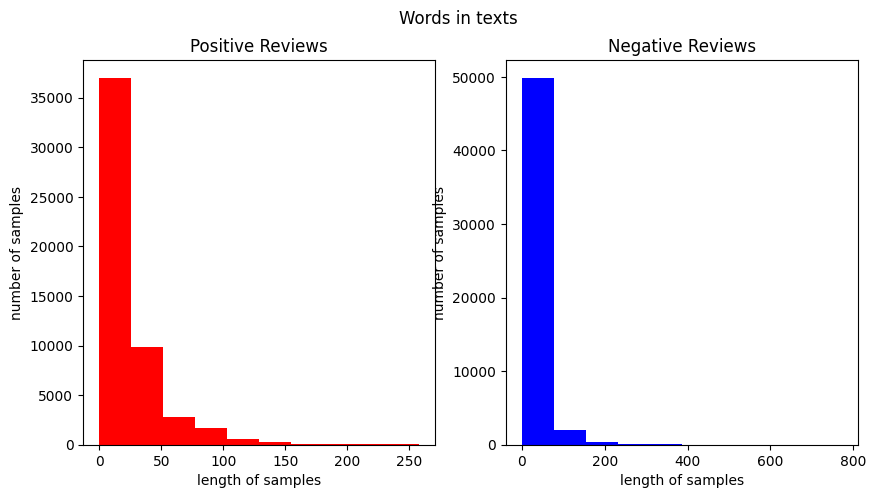

In [116]:
# 두 가지 경우에 대해서 각각 길이 분포를 확인해봅시다.

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [117]:
# 부정 리뷰보다는 긍정 리뷰가 좀 더 길게 작성된 경향이 있는 것 같습니다.

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [144]:
train_data['tokenized'].values

array([list(['난', '별로', '달다', '먼저', '왔는데도', '늦게', '온', '테이블', '세팅', '나가고', '블로그', '맛', '집', '떠서', '가봤는데', '개인', '차', '큰', '같음']),
       list(['짜가', '정말', '정말', '맛있었어요', '강', '추합니다', '또', '가고', '싶을', '정도']),
       list(['어어', '어어어어', '무', '기대해서', '런가', '별로', '였다', '딱히', '특별하지', '않은', '맛', '결정', '패티', '그랬다']),
       ..., list(['빵', '겁나', '맛없음', '커피']),
       list(['음료', '미지', '밍밍', '증편', '떡', '구이', '따뜻하긴', '내어주시는', '발사믹', '강하고', '떡', '안', '어울려요', '오픈', '기간', '방문', '지금', '좀', '나아졋길', '바랍니다']),
       list(['고등학생', '때', '진짜', '맛있게', '먹었던', '같은데', '사', '년', '지난', '후', '지금', '먹어', '보니', '달다', '악덕', '사서', '옆', '편의점', '테이블', '맥주', '사서', '먹으면', '꿀이긴'])],
      dtype=object)

In [148]:
test_data['tokenized'].values

array([list(['맛', '괜찮은지', '모르는데', '계산', '하려면', '짜증', '캐셔', '좀', '늘려서', '해소', '해주면', '좋을', '성질', '급한', '사람', '그냥', '안', '사', '먹고', '말']),
       list(['주위', '유명한', '집', '닫아서', '갔는데', '영업', '하시냐고', '주방', '할머니', '여쭤', '보니', '그냥', '들어오면', '되지', '물어봐라고', '미', '간', '찌푸리고', '짜증', '내며', '소리', '지르네요', '분노조절', '장애인', '맛', '짬뽕', '외', '성비', '최악', '결론', '불친절', '성비', '최악']),
       list(['갑작스럽게', '급', '방문', '기대', '일도', '안', '하고', '가서', '런가', '맛있게', '잘', '먹었다', '여긴', '스텔라', '피자', '꼭', '먹어야', '된다']),
       ...,
       list(['바다', '가까운데', '뷰', '좋은', '아니고', '안', '좋은', '아니고', '애매함', '자리', '쟁탈전', '치열하고', '음료', '양', '퀄리티', '비해', '매우', '비싼', '편']),
       list(['베트남', '맥주', '거리', '같은', '떠들썩하고', '와글와글', '젊은', '분위기']),
       list(['사악한', '가격', '대체재', '없으므로', '찾게', '되는', '가게', '맛', '변하지', '않았으면'])],
      dtype=object)

In [147]:
y_test

array([0, 0, 1, ..., 0, 1, 1])

In [118]:
# 7 정수 인코딩

# 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 
# 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


In [119]:
# 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 
# 이는 tokenizer.word_index를 출력하여 확인 가능합니다. 
# 등장 횟수가 1회인 단어들은 자연어 처리에서 배제하고자 합니다. 
# 이 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 87912
등장 빈도가 1번 이하인 희귀 단어의 수: 41087
단어 집합에서 희귀 단어의 비율: 46.736509236509235
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.447114136650093


In [120]:
# 단어가 약 40,000개가 존재합니다. 등장 빈도가 threshold 값인 2회 미만. 
# 즉, 1회인 단어들은 단어 집합에서 약 45% -> 50% 를 차지합니다. 
# 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 매우 적은 수치인 약 0.8% -> 4% 밖에 되지 않습니다. 
# 아무래도 등장 빈도가 1회인 단어들은 자연어 처리에서 중요하지 않을 것으로 저자는 판단했습니다. 
# 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다. 
# 등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한합니다.

# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 46827


In [145]:
# # 전부 사용

# vocab_size = total_cnt
# print('단어 집합의 크기 :',vocab_size)

In [122]:
vocab_size = total_cnt

# 단어 집합의 크기는 21,787 -> 32794개입니다. 
# 이를 토크나이저의 인자로 넘겨주고, 텍스트 시퀀스를 정수 시퀀스로 변환합니다. 
# 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환하겠습니다.

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
# X_train - 훈련 때 사용했던 data 필요
tokenizer.fit_on_texts(X_train)
# X_train - 예측시, 예측 데이터 필요
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [143]:
tokenizer.word_index

{'OOV': 1,
 '맛': 2,
 '안': 3,
 '집': 4,
 '가격': 5,
 '음식': 6,
 '정말': 7,
 '그냥': 8,
 '사람': 9,
 '방문': 10,
 '고기': 11,
 '좀': 12,
 '별로': 13,
 '때': 14,
 '잘': 15,
 '정도': 16,
 '하는': 17,
 '주문': 18,
 '있는': 19,
 '메뉴': 20,
 '직원': 21,
 '생각': 22,
 '진짜': 23,
 '못': 24,
 '먹고': 25,
 '분위기': 26,
 '다른': 27,
 '먹을': 28,
 '맛있어요': 29,
 '밥': 30,
 '서비스': 31,
 '느낌': 32,
 '손님': 33,
 '양': 34,
 '시간': 35,
 '커피': 36,
 '하나': 37,
 '좋은': 38,
 '국물': 39,
 '가게': 40,
 '추천': 41,
 '말': 42,
 '식당': 43,
 '여기': 44,
 '카페': 45,
 '먹는': 46,
 '테이블': 47,
 '먹어': 48,
 '같아요': 49,
 '빵': 50,
 '조금': 51,
 '점': 52,
 '합니다': 53,
 '줄': 54,
 '사장': 55,
 '자리': 56,
 '좋아요': 57,
 '중': 58,
 '식사': 59,
 '처음': 60,
 '기분': 61,
 '전': 62,
 '맛있는': 63,
 '하고': 64,
 '있어서': 65,
 '맛있고': 66,
 '소스': 67,
 '않고': 68,
 '같은': 69,
 '성비': 70,
 '시': 71,
 '가지': 72,
 '하면': 73,
 '주차': 74,
 '다시': 75,
 '파스타': 76,
 '튀김': 77,
 '반찬': 78,
 '없는': 79,
 '나': 80,
 '만두': 81,
 '갔는데': 82,
 '아주': 83,
 '좋고': 84,
 '없고': 85,
 '먹었는데': 86,
 '또': 87,
 '면': 88,
 '먹기': 89,
 '보고': 90,
 '기본': 91,
 '최악': 92,


In [123]:
# X_train과 X_test에 대해서 상위 3개의 샘플만 출력합니다.
print(X_train[:3])

[[496, 13, 2404, 396, 8574, 576, 224, 47, 2032, 4091, 826, 2, 4, 4409, 837, 117, 270, 256, 572], [7442, 7, 7, 93, 1088, 2678, 87, 211, 421, 16], [4496, 9238, 793, 5899, 970, 13, 590, 762, 3735, 172, 2, 2303, 933, 2317]]


In [124]:
print(X_test[:3])

[[2, 12765, 12544, 329, 3323, 451, 8877, 12, 27409, 11045, 5728, 236, 5263, 12547, 9, 8, 3, 222, 25, 42], [2718, 156, 4, 4872, 82, 518, 17312, 342, 1230, 2058, 184, 8, 5232, 1130, 1, 1586, 154, 18645, 451, 5300, 491, 25839, 1, 20238, 2, 136, 724, 70, 92, 1246, 216, 70, 92], [24669, 2175, 10, 192, 5645, 3, 64, 112, 970, 111, 15, 815, 470, 16341, 109, 141, 493, 717]]


리뷰의 최대 길이 : 773
리뷰의 평균 길이 : 27.066387668137924


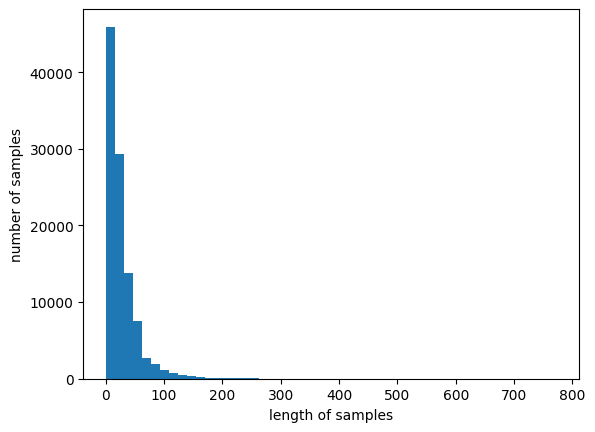

In [125]:
# 8 패딩
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 
# 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [126]:
# 리뷰의 최대 길이는 85, 평균 길이는 약 15입니다. 그래프로 봤을 때, 전체적으로는 60이하의 길이를 가지는 것으로 보입니다.
# 341 , 30 , 100
# 1130 , 34 , 300
# 274 27 250

def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [127]:
# 최대 길이가 85이므로 만약 80으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인해봅시다.
# 330 padding

max_len = 250
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 250 이하인 샘플의 비율: 99.86272509747471


In [128]:
# 훈련용 리뷰의 99.99%가 80이하의 길이를 가집니다. 훈련용 리뷰를 길이 80으로 패딩하겠습니다.
# 330 98.5%
# 250 99.9%
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


In [149]:
X_train

(104899, 250)

# 쇼핑 리뷰 감정 분류

하이퍼파라미터인 임베딩 벡터의 차원은 100, 은닉 상태의 크기는 128입니다. 모델은 다 대 일 구조의 LSTM를 사용합니다. 해당 모델은 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델입니다. 이진 분류 문제의 경우, 출력층에 로지스틱 회귀를 사용해야 하므로 활성화 함수로는 시그모이드 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용합니다. 하이퍼파라미터인 배치 크기는 64이며, 15 에포크를 수행합니다.

EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미입니다. ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다. validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다. 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용됩니다.

In [129]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from konlpy.tag import Okt

okt = Okt()
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid')) # 활성화 함수

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

mc = ModelCheckpoint(r'/content/drive/MyDrive/data_review/archive/new_model_01_v2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=8, callbacks=[es, mc], batch_size=64, validation_split=0.2)


Epoch 1/8
1312/1312 [==============================] - ETA: 0s - loss: 0.2378 - acc: 0.9042
Epoch 1: val_acc improved from -inf to 0.92998, saving model to /content/drive/MyDrive/data_review/archive/new_model_01_v2.h5
1312/1312 [==============================] - 914s 691ms/step - loss: 0.2378 - acc: 0.9042 - val_loss: 0.1854 - val_acc: 0.9300
Epoch 2/8
1312/1312 [==============================] - ETA: 0s - loss: 0.1569 - acc: 0.9428
Epoch 2: val_acc improved from 0.92998 to 0.93170, saving model to /content/drive/MyDrive/data_review/archive/new_model_01_v2.h5
1312/1312 [==============================] - 910s 693ms/step - loss: 0.1569 - acc: 0.9428 - val_loss: 0.1800 - val_acc: 0.9317
Epoch 3/8
1312/1312 [==============================] - ETA: 0s - loss: 0.1294 - acc: 0.9539
Epoch 3: val_acc improved from 0.93170 to 0.93642, saving model to /content/drive/MyDrive/data_review/archive/new_model_01_v2.h5
1312/1312 [==============================] - 896s 683ms/step - loss: 0.1294 - acc: 0.9

In [130]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from konlpy.tag import Okt

In [131]:
model.save(r'/content/drive/MyDrive/data_review/archive/new_model_01__v2_save.h5')

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim))
model2.add(GRU(hidden_units))
model2.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

mc2 = ModelCheckpoint(r'/content/drive/MyDrive/data_review/archive/new_model_02.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# mc2 = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=5, callbacks=[es, mc2], batch_size=64, validation_split=0.2)

Epoch 1/5
1312/1312 [==============================] - ETA: 0s - loss: 0.0493 - acc: 0.9850
Epoch 1: val_acc improved from -inf to 0.93189, saving model to /content/drive/MyDrive/data_review/archive/new_model_02.h5
1312/1312 [==============================] - 861s 657ms/step - loss: 0.0493 - acc: 0.9850 - val_loss: 0.2245 - val_acc: 0.9319
Epoch 2/5
1312/1312 [==============================] - ETA: 0s - loss: 0.0395 - acc: 0.9883
Epoch 2: val_acc did not improve from 0.93189
1312/1312 [==============================] - 874s 666ms/step - loss: 0.0395 - acc: 0.9883 - val_loss: 0.2676 - val_acc: 0.9289
Epoch 3/5
1312/1312 [==============================] - ETA: 0s - loss: 0.0315 - acc: 0.9911
Epoch 3: val_acc did not improve from 0.93189
1312/1312 [==============================] - 882s 672ms/step - loss: 0.0315 - acc: 0.9911 - val_loss: 0.2739 - val_acc: 0.9243
Epoch 4/5
1312/1312 [==============================] - ETA: 0s - loss: 0.0246 - acc: 0.9927
Epoch 4: val_acc did not improve fro

In [ ]:
model2.save(r'/content/drive/MyDrive/data_review/archive/new_model_02_save.h5')

# 테스트

In [132]:
# loaded_model = load_model('best_model.h5')
loaded_model = load_model(r'/content/drive/MyDrive/data_review/archive/new_model_01_v2.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))



1093/1093 [==============================] - 74s 67ms/step - loss: 0.1658 - acc: 0.9370

 테스트 정확도: 0.9370


In [ ]:
loaded_model.summary()

In [ ]:
X_test.shape

# 로딩 후 예측

In [ ]:
  review_df = review_data_frm_03[:100].copy()
  # test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
  review_df['리뷰'] = review_df.리뷰.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
  review_df['리뷰'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
  # df_cleaned = df.dropna(subset=['리뷰'])
  review_df['리뷰'] = review_df['리뷰'].astype(str)
# 불용어를 지정하여 필요없는 토큰들은 제거하도록 합니다.

  stopwords = ['도', '는', '다', '의', '가', '이', '은', 
              '한', '에', '하', '고', '을', '를', '인', '듯', 
              '과', '와', '네', '들', '듯', '지', '임', '게' , 
              '는' ,'이','인데','이가','했었','했','습니다','슴','음' ,
              '것' ,'거' ,'로' ,'들' ,'거' ,'것' ,'곳' , '분' , '원' ,
              '입니다' ,'해서' ,'더' ,'왜' ,'수' ,'할' , '그' ,'함' ,'돈' ,'번' ,
              '두' ,'개' ,'했는데' ,'건' ,'내' , '저' ,'만' ,'갈','걸','제','명' ,
              '분' ,'해']

  review_df['tokenized'] = review_df['리뷰'].apply(okt.pos)
  review_df['tokenized'] = review_df['tokenized'].apply(lambda x: [word for word,shape in x if shape in ['Verb' , 'Adjective' , 'Noun' , 'VerbPrefix'] if word not in stopwords])


In [ ]:
review_df['tokenized']

0                                                   [굳]
1     [이번, 갔을, 때, 탕수육, 튀겨서, 그런지, 딱딱했어요, 여기, 좋아했는데, 이...
2                 [늘, 먹는, 세트, 오늘, 삼선, 간짜장, 바꿨지만, 맛, 보장]
3                                                [맛있어요]
4                                                 [좋아요]
                            ...                        
95    [시, 늦게, 별로, 없어, 방문, 짬뽕, 간짜장, 맛집, 발견, 서울, 요새, 짬...
96            [간짜장, 맛집, 양도, 많아요, 탕수육, 고기, 맛있는데, 소스, 별로]
97                                                [좋아요]
98                              [제주, 제일, 맛있는, 집자주, 갑니다]
99                                           [정말, 맛있어요]
Name: tokenized, Length: 100, dtype: object

In [ ]:
# 부정 리뷰보다는 긍정 리뷰가 좀 더 길게 작성된 경향이 있는 것 같습니다.

X_review= review_df['tokenized'].values

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_review)
X_review = tokenizer.texts_to_sequences(X_review)
max_len = 250

# 훈련용 리뷰의 99.99%가 80이하의 길이를 가집니다. 훈련용 리뷰를 길이 80으로 패딩하겠습니다.
# 330 98.5%
# 250 99.9%

X_review = pad_sequences(X_review, maxlen=max_len)


In [ ]:
X_review.shape

(100, 250)

In [ ]:
# 테스트 데이터에 대한 예측 수행
predictions = loaded_model.predict(X_review)
# 예측 결과 출력
for sentense, prediction in zip(review_df.리뷰.tolist() , predictions):
    print(sentense)
    if prediction > 0.95:
        print("리뷰 %f: 긍정 리뷰" %(prediction*100))
    elif prediction < 0.05 :
        print("리뷰 %f: 부정 리뷰" %(prediction*100))
    else:
        print("리뷰 %f: 중립 리뷰" %(prediction*100))

    print()

4/4 [==============================] - 1s 111ms/step
굳
리뷰 3.044910: 부정 리뷰

이번에 갔을 때는 탕수육을 너무 튀겨서 그런지 딱딱했어요ㅠ 여기 좋아했는데 이번꺼는 눈으로 봐도 탕수육이 너무 타서 먹기 힘들었습니다
리뷰 99.011398: 긍정 리뷰

늘 먹는 세트에요 오늘은 삼선간짜장으로 바꿨지만 맛은 보장입니다
리뷰 96.126770: 긍정 리뷰

맛있어요
리뷰 3.941276: 부정 리뷰

좋아요
리뷰 2.735976: 부정 리뷰

맛있어요
리뷰 3.941276: 부정 리뷰

굳
리뷰 3.044910: 부정 리뷰

가성비 굿
리뷰 3.974684: 부정 리뷰

물 짜장면
리뷰 0.559980: 부정 리뷰

맛있어요
리뷰 3.941276: 부정 리뷰

배달짬뽕맛을 제주까지와서 먹을줄이야제주도에서 수많은짬뽕을 주문해봤지만 가장 맛이없었던곳
리뷰 95.399323: 긍정 리뷰

제입맛에는 그냥 일반적이예요
리뷰 15.556450: 중립 리뷰

괜찮아요
리뷰 6.388454: 중립 리뷰

공항에서 급하게 갔는데 양이 푸짐해요맛있게 잘 먹었습니다
리뷰 6.108028: 중립 리뷰

굳
리뷰 3.044910: 부정 리뷰

재료아끼지않고 양도 많고 맛도좋고
리뷰 96.192589: 긍정 리뷰

삼선고추짬뽕밥 진짜 최고입미다ㅜㅜ
리뷰 1.020688: 부정 리뷰

간짜장 정말 별로네요무슨맛인지
리뷰 87.190834: 중립 리뷰

nan
리뷰 1.388640: 부정 리뷰

탕수육 굳
리뷰 8.079066: 중립 리뷰

딱 깔끔한 맛의 삼선 고추 짬뽕 먹고 나서 속 불편하거나 그런 거 없이 좋았어요 맵기 조정 가능하다구 하더라구요
리뷰 74.694740: 중립 리뷰

탕수육 맛있네요 ㅎㅎ
리뷰 2.935617: 부정 리뷰

탕수육 짱
리뷰 18.881893: 중립 리뷰

굿
리뷰 1.585420: 부정 리뷰

굿 짜장면맛있어요
리뷰 1.223020: 부정 리뷰

맛나요
리뷰 2.079522: 부정 리뷰

맛있어요
리뷰

In [ ]:
# 테스트 데이터에 대한 예측 수행
predictions = loaded_model.predict(X_test)
# 예측 결과 출력
for i, prediction in enumerate(predictions):
    if prediction > 0.5:
        print("리뷰 %d: 긍정 리뷰" % (i+1))
    else:
        print("리뷰 %d: 부정 리뷰" % (i+1))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
리뷰 29967: 긍정 리뷰
리뷰 29968: 부정 리뷰
리뷰 29969: 긍정 리뷰
리뷰 29970: 부정 리뷰
리뷰 29971: 부정 리뷰
리뷰 29972: 긍정 리뷰
리뷰 29973: 부정 리뷰
리뷰 29974: 긍정 리뷰
리뷰 29975: 긍정 리뷰
리뷰 29976: 부정 리뷰
리뷰 29977: 긍정 리뷰
리뷰 29978: 긍정 리뷰
리뷰 29979: 부정 리뷰
리뷰 29980: 부정 리뷰
리뷰 29981: 긍정 리뷰
리뷰 29982: 부정 리뷰
리뷰 29983: 긍정 리뷰
리뷰 29984: 긍정 리뷰
리뷰 29985: 부정 리뷰
리뷰 29986: 긍정 리뷰
리뷰 29987: 긍정 리뷰
리뷰 29988: 부정 리뷰
리뷰 29989: 긍정 리뷰
리뷰 29990: 부정 리뷰
리뷰 29991: 부정 리뷰
리뷰 29992: 긍정 리뷰
리뷰 29993: 부정 리뷰
리뷰 29994: 긍정 리뷰
리뷰 29995: 긍정 리뷰
리뷰 29996: 부정 리뷰
리뷰 29997: 부정 리뷰
리뷰 29998: 긍정 리뷰
리뷰 29999: 부정 리뷰
리뷰 30000: 부정 리뷰
리뷰 30001: 부정 리뷰
리뷰 30002: 긍정 리뷰
리뷰 30003: 긍정 리뷰
리뷰 30004: 부정 리뷰
리뷰 30005: 부정 리뷰
리뷰 30006: 부정 리뷰
리뷰 30007: 긍정 리뷰
리뷰 30008: 긍정 리뷰
리뷰 30009: 부정 리뷰
리뷰 30010: 긍정 리뷰
리뷰 30011: 부정 리뷰
리뷰 30012: 부정 리뷰
리뷰 30013: 긍정 리뷰
리뷰 30014: 부정 리뷰
리뷰 30015: 부정 리뷰
리뷰 30016: 긍정 리뷰
리뷰 30017: 긍정 리뷰
리뷰 30018: 부정 리뷰
리뷰 30019: 부정 리뷰
리뷰 30020: 부정 리뷰
리뷰 30021: 긍정 리뷰
리뷰 30022: 부정 리뷰
리뷰 30023: 긍정 리뷰
리뷰 30024: 부정 리뷰
리뷰 30025: 부정 리뷰
리뷰 30026: 부정 리뷰
리뷰 3

In [ ]:
# loaded_model = load_model('best_model.h5')
loaded_model2 = load_model(r'/content/drive/MyDrive/data_review/archive/model_14hs_02.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model2.evaluate(X_test, y_test)[1]))



1093/1093 [==============================] - 82s 72ms/step - loss: 0.2309 - acc: 0.9294

 테스트 정확도: 0.9294


# test 접기

In [ ]:
testing = pd.read_excel('/content/drive/MyDrive/data_review/archive/(주)시더스초밥제주연동점_review.xlsx')

In [ ]:
testing = pd.read_excel('/content/drive/MyDrive/data_review/archive/(주)서촌제 스시100_review.xlsx')

In [ ]:
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# es: 조기 종료(Early Stopping) 콜백입니다. 학습 도중에 모니터링할 지표를 지정하고
# 지정한 지표가 개선되지 않을 경우 학습을 조기에 종료시킵니다. 이를 통해 과적합을 방지하고, 최적의 모델을 얻을 수 있습니다.

# patience: patience는 early stopping에서 성능 향상을 기다리는 epoch 수를 지정하는 매개변수입니다. 
# 예를 들어, patience=5로 설정하면, 검증 손실이 5번 이상 개선되지 않으면 학습을 조기 종료합니다

# mc: 모델 체크포인트(Model Checkpoint) 콜백입니다. 학습 도중에 모델의 가중치를 저장하는 역할을 합니다. 
# 지정한 지표가 개선될 때마다 모델을 저장하여 최고의 성능을 보이는 모델을 얻을 수 있습니다.

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(r'/content/drive/MyDrive/data_review/archive/test_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=3, callbacks=[es, mc], batch_size=64, validation_split=0.4)

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
a = [1,2,3,4,5]
b = [77,6,7,8,9]
a.extend(b)
a

In [ ]:
plus = ['은','는','님' ,'하지' , '달' , '도' , '고'  ]
stopwords

# 리뷰 예측해보기

임의의 문장에 대한 예측을 위해서는 학습하기 전 전처리를 동일하게 적용해줍니다. 전처리의 순서는 정규 표현식을 통한 한국어 외 문자 제거, 토큰화, 불용어 제거, 정수 인코딩, 패딩 순입니다.


## test

In [ ]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]

    #print('new_sentence : ' , new_sentence)

    encoded = tokenizer.texts_to_sequences([new_sentence])

    #print(encoded)
    pad_new = pad_sequences(encoded, maxlen = max_len)
    
    #print(pad_new)

    score = float(loaded_model.predict(pad_new))
    if (score > 0.5):
      print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else :
      print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))


In [ ]:
# test_re = pd.read_csv('/content/drive/MyDrive/(주)시더스초밥제주연동점_review.csv' , encoding = 'euc-kr')

In [ ]:
test_re = testing

In [ ]:
test_re.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   리뷰        429 non-null    object
 1   리뷰이미지url  150 non-null    object
 2   작성자프로필    445 non-null    object
 3   My플레이스    445 non-null    object
 4   작성자이름     445 non-null    object
 5   리뷰작성수     445 non-null    object
 6   리뷰작성일     445 non-null    object
 7   식당방문수     445 non-null    object
 8   리뷰인증방식    445 non-null    object
 9   식당id      445 non-null    int64 
 10  사업장명      445 non-null    object
dtypes: int64(1), object(10)
memory usage: 38.4+ KB


In [ ]:
test_re = testing.리뷰

In [ ]:
test_re = test_re.dropna().reset_index(drop=True)

In [ ]:
for num , i in enumerate(test_re.tolist()) :
  print(num)
  print(i)
  print(sentiment_predict(i))
  print()


In [ ]:
def sentiment_predict2(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]

    #print('new_sentence : ' , new_sentence)

    encoded = tokenizer.texts_to_sequences([new_sentence])

    #print(encoded)
    pad_new = pad_sequences(encoded, maxlen = max_len)

    #print(pad_new)

    score = float(loaded_model2.predict(pad_new))
    if (score > 0.5):
      print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else :
      print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))


In [ ]:
for num , i in enumerate(test_re.tolist()) :
  print(num)
  print(i)
  # print()
  print(sentiment_predict2(i))
  print()


## 예측 후 저장하기

In [133]:
def review_predict(new_sentence):
  
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]

    #print('new_sentence : ' , new_sentence)

    if new_sentence == '' :
      print('정규화 후, 리뷰 데이터가 남아있지 않습니다.')
      return '-1'
    else :
      pass

    encoded = tokenizer.texts_to_sequences([new_sentence])

    #print(encoded)
    max_len = 250
    pad_new = pad_sequences(encoded, maxlen = max_len)

    #print(pad_new)

    score = float(loaded_model.predict(pad_new))
    if (score > 0.95):
      print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
      return '0'
    elif (score < 0.05) :
      print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))
      return '1'
    else :
      print("{:.2f}% 확률로 중립 리뷰입니다.".format(score * 100))
      return '2'


In [134]:
review_data_frm_01 = pd.read_excel('/content/drive/MyDrive/Crawling/제주특별자치도/제주시/식당정보/제주특별자치도_제주시_연동_리뷰전체모음_01.xlsx')

In [135]:
review_data_frm_02 = pd.read_excel('/content/drive/MyDrive/Crawling/제주특별자치도/제주시/식당정보/제주특별자치도_제주시_연동_리뷰전체모음_02.xlsx')

In [136]:
review_data_frm_03 = pd.read_excel('/content/drive/MyDrive/Crawling/제주특별자치도/제주시/식당정보/제주특별자치도_제주시_연동_리뷰전체모음_03.xlsx')

In [137]:
review_data_frm_04 = pd.read_excel('/content/drive/MyDrive/Crawling/제주특별자치도/제주시/식당정보/제주특별자치도_제주시_연동_리뷰전체모음_04.xlsx')

In [138]:
review_01 = review_data_frm_01.리뷰
review_02 = review_data_frm_02.리뷰
review_03 = review_data_frm_03.리뷰
review_04 = review_data_frm_04.리뷰

In [139]:
print(review_01.isnull().sum())
print(review_02.isnull().sum())
print(review_03.isnull().sum())
print(review_04.isnull().sum())

0
0
0
0


### 1

In [ ]:
label_lst_01 = []

for num , i in enumerate(review_01.tolist()) :
  print(num)
  print(i)
  # review_predict(i)
  label_lst_01.append(review_predict(i))
  print()
  
review_data_frm_01['label'] = label_lst_01
review_data_frm_01.to_excel('/content/drive/MyDrive/Crawling/제주특별자치도/제주시/식당정보/제주특별자치도_제주시_연동_긍부정판단_01.xlsx' , index=False)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
정말 케이크맛집에오~~!하나로는참을수없는맛ㅎㅎ
1/1 [==============================] - 0s 26ms/step
51.25% 확률로 중립 리뷰입니다.

19099
케이크맛집 이번달만 두번왔음
1/1 [==============================] - 0s 29ms/step
38.19% 확률로 중립 리뷰입니다.

19100
케익 맛있어요!
겨울인데 난방이 약해서 아쉬웠어요
1/1 [==============================] - 0s 29ms/step
78.78% 확률로 중립 리뷰입니다.

19101
단팥죽만 맛있는 줄 알았는데 진저라떼도 스콘도 아주 맛있네요. 인테리어도 예쁘고.
1/1 [==============================] - 0s 27ms/step
99.81% 확률로 긍정 리뷰입니다.

19102
인테리어 세련. 빵도 커피도 맛있고 단팥죽 아주 든든해요
1/1 [==============================] - 0s 26ms/step
99.33% 확률로 긍정 리뷰입니다.

19103
디저트 맛집이라 해서 친구 데리고 갔는데 별로라고 하네요ㅡㅜ
1/1 [==============================] - 0s 27ms/step
95.21% 확률로 부정 리뷰입니다.

19104
수능선물로 호두파이를 ^^ 파이맛집입니다
1/1 [==============================] - 0s 30ms/step
93.12% 확률로 중립 리뷰입니다.

19105
파이맛집 이지만 생강차도 넘 좋네요
1/1 [==============================] - 0s 27ms/step
96.62% 확률로 긍정 리뷰입니다.

19106
지나가다 우연히 들렸어용
땅콩쿠키 꼭 드셔보세요 꼬숩고 맛나요
커피는 말해뭐해요 맛있습니다~
1/1 [==============================] - 0s 26ms/

### 2

In [ ]:
label_lst_02 = []

for num , i in enumerate(review_02.tolist()) :
  print(num)
  print(i)
  # review_predict(i)
  label_lst_02.append(review_predict(i))
  print()
  
review_data_frm_02['label'] = label_lst_02
review_data_frm_02.to_excel('/content/drive/MyDrive/Crawling/제주특별자치도/제주시/식당정보/제주특별자치도_제주시_연동_긍부정판단_02.xlsx' , index=False)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
19124
고기국수 먹어본중 제일이예요
1/1 [==============================] - 0s 51ms/step
14.87% 확률로 중립 리뷰입니다.

19125
제주도는 대부분 음식양이 너무 많은것같아요.. 맛은 있는데 면 양이 너무 많아서 거의다 남겼어요. 3인이서 국수3개랑 만두 시켰는데 국수 2개만 시켜도 되었을 정도로 양이 많았어요.
1/1 [==============================] - 0s 41ms/step
92.70% 확률로 중립 리뷰입니다.

19126
맛있음. 주차는 신제주공영주차장 이용.
일하시는분들 친절하심.
1/1 [==============================] - 0s 50ms/step
99.12% 확률로 긍정 리뷰입니다.

19127
띤맛집 양마나요
1/1 [==============================] - 0s 43ms/step
52.19% 확률로 중립 리뷰입니다.

19128
고기국수와 멸치국수 먹었어요. 제주 3대국수 이런곳들보다 훨씬 더 맛있었어요 !! 양도많고 친절하십니다~ 고기도 야들야들하고 고기도 국수도 양이 많았어요. 깍두기 국물도 시원합니다ㅎㅎ 또 가고싶어요 !
1/1 [==============================] - 0s 41ms/step
99.13% 확률로 긍정 리뷰입니다.

19129
오픈시간 얼마 안되서 갔는데도 한 40-50분은 기다렸던 것 같아욤..! 완전 맛집이라구 해서 웨이팅하고 먹었는데 진짜 양도 엄청많고 ㅜㅜㅜㅜ너무너무너무 맛있었어요..!! 기다려서 먹을만함..!!!🥰💜💜 또가구싶어욤
1/1 [==============================] - 0s 41ms/step
99.00% 확률로 긍정 리뷰입니다.

19130
비빔이 먹고싶어서 왔는데 고기국수가 더 찐이에요 국물 딱 적당히진하고 감칠맛나고 고기 맛있고 안짜고 짱 맛있어요. 비빔 야채도 많아서 양념이랑 맛있

### 3

In [ ]:
label_lst_03 = []

for num , i in enumerate(review_03.tolist()) :
  print(num)
  print(i)
  # review_predict(i)
  label_lst_03.append(review_predict(i))
  print()
  
review_data_frm_03['label'] = label_lst_03
review_data_frm_03.to_excel('/content/drive/MyDrive/Crawling/제주특별자치도/제주시/식당정보/제주특별자치도_제주시_연동_긍부정판단_03.xlsx' , index=False)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
19168
굿
1/1 [==============================] - 0s 41ms/step
91.23% 확률로 중립 리뷰입니다.

19169
맛있고 양많아요. 직원분들도 친절합니다^^
1/1 [==============================] - 0s 43ms/step
98.70% 확률로 긍정 리뷰입니다.

19170
사무실 근처라 가봤는데 맛있어요
1/1 [==============================] - 0s 42ms/step
92.91% 확률로 중립 리뷰입니다.

19171
구
1/1 [==============================] - 0s 48ms/step
98.71% 확률로 부정 리뷰입니다.

19172
굿
1/1 [==============================] - 0s 51ms/step
91.23% 확률로 중립 리뷰입니다.

19173
짜장면 맛집임!!!
ㅈㄴ맛있음
1/1 [==============================] - 0s 36ms/step
85.72% 확률로 중립 리뷰입니다.

19174
짬뽕이 해물이 많아서 좋았고 짬뽕 짜장 둘 다 양도 많고 아주 맛있었습니다~~ 직원분도 친절하고 아주 기분 좋게 밥 먹었어요!!
1/1 [==============================] - 0s 44ms/step
99.88% 확률로 긍정 리뷰입니다.

19175
고추짬뽕, 탕수육 모두 만족스럽네요
1/1 [==============================] - 0s 44ms/step
75.32% 확률로 중립 리뷰입니다.

19176
저는 짬뽕파라 다른 맛집에 가도 자장면을 몇 입 먹고 마는데, 여기 자장면은 고추장 솔솔 뿌려 먹으니 다먹었어요 ㅎㅎ
근데 가격도 5천원.. 사장님 감사합니다..ㅠㅠ
짬뽕은 해산물 향이 강해 호불호가 있읕 것 같지만 살짝 매콤맛잇습니당
면은 얇은 편입니당!

탕수육 부먹인 게 아쉬워요..

###4

In [140]:
label_lst_04 = []

for num , i in enumerate(review_04.tolist()) :
  print(num)
  print(i)
  # review_predict(i)
  label_lst_04.append(review_predict(i))
  print()
  
review_data_frm_04['label'] = label_lst_04
review_data_frm_04.to_excel('/content/drive/MyDrive/Crawling/제주특별자치도/제주시/식당정보/제주특별자치도_제주시_연동_긍부정판단_04.xlsx' , index=False)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
95.81% 확률로 부정 리뷰입니다.

16590
원래 가려고 했던곳이 월요일 휴무라 급하게 네이버 검색으로 찾아갔는데 양도 많고 맛도 괜찮았습니다~
1/1 [==============================] - 0s 61ms/step
42.63% 확률로 중립 리뷰입니다.

16591
왜 줄서서 먹는지 모르겠어요 국수는 불어있고
양은 많아요
1/1 [==============================] - 0s 67ms/step
97.20% 확률로 부정 리뷰입니다.

16592
메뉴가 한가지라 고민할 것도 없었네요. 고기 부드럽고 국물이랑 김치도 맛있습니다. 면은 약간 불어있긴했는데 괜찮았어요. 비행기타기전에 들러서 먹었는데 간단하게(?) 먹기 좋았어요.
1/1 [==============================] - 0s 61ms/step
99.61% 확률로 긍정 리뷰입니다.

16593
메뉴가 고기국수 하나인데 음식 빨리 나오고 후루룩 먹고 나오기 좋아요. 면발이 우동스러운데 맑은 국물에 고기도 쫄깃 맛있어요^^
1/1 [==============================] - 0s 77ms/step
99.67% 확률로 긍정 리뷰입니다.

16594
맛있는 국수 김치도 맛있고 고기도 두툼하고 배고프지 않았는데 다 먹게 되네요.
1/1 [==============================] - 0s 62ms/step
97.45% 확률로 긍정 리뷰입니다.

16595
존맛탱
1/1 [==============================] - 0s 72ms/step
74.58% 확률로 중립 리뷰입니다.

16596
최고최고
1/1 [==============================] - 0s 69ms/step
99.47% 확률로 긍정 리뷰입니다.

16597
맛있어요
1/1 [==============================] - 0s 66ms/step
97.45

In [ ]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

1/1 [==============================] - 0s 28ms/step
99.79% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

1/1 [==============================] - 0s 33ms/step
87.56% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

1/1 [==============================] - 0s 29ms/step
96.37% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('완전 최고에요 짱짱')

1/1 [==============================] - 0s 44ms/step
98.46% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('정말 별로입니다.')

1/1 [==============================] - 0s 71ms/step
84.65% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('참 정말 좋은 제품이네요 ㅎㅎ')

1/1 [==============================] - 0s 21ms/step
95.60% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('진짜 사람 미치게 만듭니다 ㅋㅋ')

1/1 [==============================] - 0s 20ms/step
57.67% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('정말 최고군요? ㅎㅎ')

1/1 [==============================] - 0s 25ms/step
97.37% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('너 참 대단하다')

1/1 [==============================] - 0s 20ms/step
88.99% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('너 정말 얌샘이구나?')

new_sentence :  ['정말', '얌샘', '이구나']
[[1, 1, 1]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]]
1/1 [==============================] - 0s 35ms/step
84.65% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('너 진짜 똑똑하다.')

1/1 [==============================] - 0s 183ms/step
83.17% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('오래된 맛 집이나 순대나 고기에서 냄새가 날 때가 있고 가격에 비해 퀄리티가 괜찮은지는 의문')

1/1 [==============================] - 0s 94ms/step
93.85% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('댓글 읽어보니 느끼는 건 다 비슷한가 봄 사장님의 불친절한 말투와 뻣뻣함 누룽지탕은 해물이 빈약함 탕수육은 고기는 괜찮은데 바삭하지 않고 눅눅한 식감  탕수육은 다시 먹고 싶지 않았고  물김치는 달고 백김치도 달고  그래도 누룽지탕은 먹을만했음')

new_sentence :  ['댓글', '읽어', '보니', '느끼는', '건', '다', '비슷한가', '봄', '사장', '님', '불친절한', '말투', '뻣뻣함', '누룽지', '탕', '은', '해물', '빈약함', '탕수육', '은', '고기', '는', '괜찮은데', '바삭', '하지', '않고', '눅눅한', '식감', '탕수육', '은', '다시', '먹고', '싶지', '않았고', '물김치', '는', '달', '고', '백김치', '도', '달', '고', '누룽지', '탕', '은', '먹을만', '했음']
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
1/1 [==============================] - 0s 60ms/step
97.82% 확률로 긍정 리뷰입니다.
